# Session 3: Fitting polynomials

_Script author: louise.dash@ucl.ac.uk    
Updated: 21/01/2021_

<div class="alert alert-success"> <p><b>Intended learning outcomes:</b></p>
By the end of this session, you should be able to:
<ul>
<li> Use Python to fit a set of data to a polynomial; </li>
<li> To evaluate the goodness of fit using the matrix of covariance and Chi^2</li>
<li> Fit the residuals to a Gaussian. </li>
</div>

## Why fit to a polynomial?

In physics we often meet an experimental relation between variables which is difficult to describe mathematically. This may either be because the theoretical equation which describes the observed behaviour is difficult to solve, or because the situation is complicated by several ill-defined factors and it is difficult to derive any theoretical equation which can describe it properly. However, we can still measure the dependence between the variables experimentally and we would like to have some means of predicting this dependence. In this kind of situation it is convenient to fit an equation to our experimental data. We can then use the fitted equation to interpolate, i.e. to calculate the expected value of a variable between our measured data points, and to extrapolate, i.e. to calculate the expected value beyond the range of our measured data points. This procedure is often called “parameterizing” the relationship.

In principle we could use any form of equation to fit a set of measured data, but if we have no theoretical basis for fitting a particular type of curve it is often simplest and easiest to fit a polynomial. The order of the polynomial and the coefficients of each term in the fitted equation are called the “parameters” of our fit.

In this session we will look at how to fit polynomials with numpy, using experiment E5 as an example - you may be doing this experiment yourself in the second half of term. The experiment involves calibrating a temperature sensor by measuring its output voltage over a range of temperature. A polynomial equation is then fitted to the experimental results and this calibration equation is later input into a programmable chip so that the sensor can operate as a digital thermometer.

## Using numpy to fit a polynomial to a dataset

The first thing we need to do is import the modules we'll need. 

In [1]:
# backend for interactive plots
%matplotlib notebook

# importing numpy and plotting modules
import numpy as np
import matplotlib.pyplot as plt

# include borders for histograms etc
plt.rcParams["patch.force_edgecolor"] = True

Now we should load our data file, which is called "studentdataE5.txt". This data file contains two columns, the first is the temperature in Celsius, the second the measured voltage (V). 


<div class='alert alert-success'> 
In the code cell below:
<ul>
<li> Load the data file using np.loadtxt, and unpack it into two arrays called `temp` and `voltage`. </li>
<li> Plot it on a (labelled!) graph, using data points only (no line). </li>
</ul>

</div>

<IPython.core.display.Javascript object>


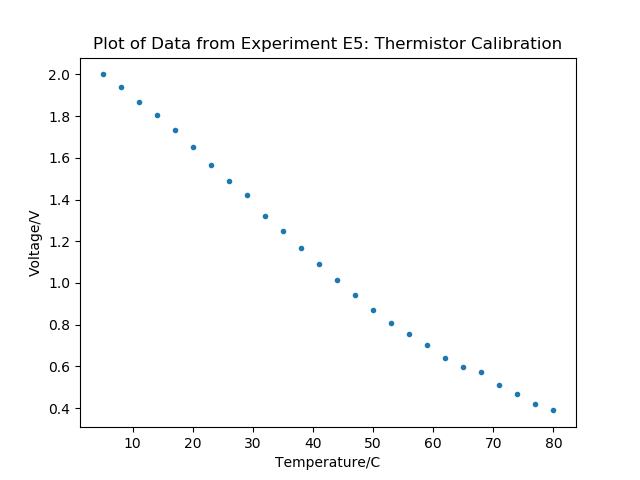

In [2]:
### STUDENT GENERATED CELL ###
temp, voltage = np.loadtxt("studentdataE5.txt", unpack=True) #load and unpack data

#plot the graph:
plt.figure()
plt.plot(temp, voltage, '.')
plt.title("Plot of Data from Experiment E5: Thermistor Calibration")
plt.xlabel("Temperature/C")
plt.ylabel("Voltage/V")
plt.show()

### Numpy's polyfit function(s)

Fortunately, we can get numpy to do all the hard work of fitting for us, by using the * **polyfit** * function. The documentation for this is here: http://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html - have a quick look at this before proceeding.

The cell below shows an example usage of np.polyfit to fit our data to a polynomial of degree 2. To run it, change "temp" and "voltage" to whatever you are using as the relevant variable names.

In [4]:
degree = 2 # degree of polynomial we want to fit to
p = np.polyfit(temp,voltage,degree)
print ("The fitted polynomial coefficients are", p)

The fitted polynomial coefficients are [ 1.06532357e-04 -3.15934839e-02  2.21148238e+00]


***IMPORTANT NOTE:*** Numpy actually has two versions of polyfit. `numpy.polyfit`, and  `numpy.polynomial.polynomial.polyfit`. They are almost identical, and are used in the same way. But look at the one crucial difference:

In [5]:
p = np.polyfit(temp,voltage,degree)
print ("np.polyfit returns the coefficients as", p)
pp = np.polynomial.polynomial.polyfit(temp,voltage,degree)
print ("np.polynomial.polynomial.polyfit returns the coefficients as", pp)

np.polyfit returns the coefficients as [ 1.06532357e-04 -3.15934839e-02  2.21148238e+00]
np.polynomial.polynomial.polyfit returns the coefficients as [ 2.21148238e+00 -3.15934839e-02  1.06532357e-04]


`numpy.polyfit` (our `np.polyfit`) returns the coefficients with the highest power first, but `numpy.polynomial.polynomial.polyfit` returns the lowest power first. This is daft.
  
However, it is an important reminder of *why* we import our modules with named abbreviations - it makes it clear which version of which module function we're using!

### Plotting fitted polynomials

Now we have our polynomial coefficients, we probably want to plot this polynomial to see how good the fit is. We could construct an expresssion for this from the elements of p, but there's a much easier way to do this with the numpy function `poly1d()` (http://docs.scipy.org/doc/numpy/reference/generated/numpy.poly1d.html ), which will convert the array of polynomial coefficients $p$ into a function that we can call to generate the value of the polynomial for a given value of $x$. The following code cell does this by using np.poly1d to create a _function_ called "line":

In [6]:
line = np.poly1d(p)

# output the result of this as a (rather poorly formatted!) algebraic expression of the polynomial
print(line)

# Example: evaluate this polynomial at x = 42
print("When x = 42 this polynomial has the value", line(42))

           2
0.0001065 x - 0.03159 x + 2.211
When x = 42 this polynomial has the value 1.0724791290191296


<div class='alert alert-success'> 

Now you need to:
<ul>
<li> Generate an array of x-values to fit the data to </li>
<li> Use the "line" function we just created to generate a corresponding array of y-values.</li>
<li> Plot the original data (as points) and the fitted line (as a line) on a labelled graph.</li>
</ul>
Do this in the cell below.
</div>

<IPython.core.display.Javascript object>


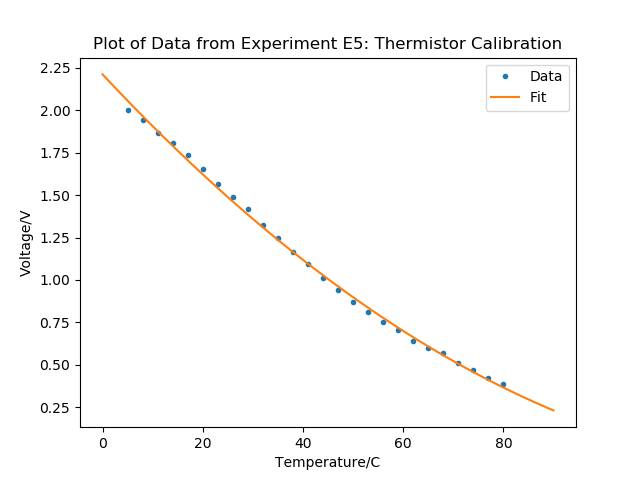

In [7]:
### STUDENT GENERATED CELL ###

x_values = np.linspace(0,90,10000) #array of x values
y_values = line(x_values) #corresponging y values

#plot:
plt.figure()
plt.plot(temp, voltage, '.', label="Data")
plt.plot(x_values,y_values, label="Fit")
plt.title("Plot of Data from Experiment E5: Thermistor Calibration")
plt.xlabel("Temperature/C")
plt.ylabel("Voltage/V")
plt.legend()
plt.show()

At first glance, this second-order polynomial looks okayish (or it should do if you've done it right!) - but with definite room for improvement.

But how good is the fit really?

## Goodness of fit (1) - calculating the errors on the coefficients and the matrix of covariance.

We'll recalculate, this time with an important addition to the polyfit call - we'll ask it to also calculate the matrix of covariance.

(A Python aside: In the cell below, there's also a line that limits the number of decimal places that are displayed when we print a numpy array. This is just for convenience - compare this with the arrays printed out at full precision above: which do you find easier to read? You can change the number of decimal points displayed to whatever you want. Note that this will affect _all_ arrays printed after this line is run, but won't affect the formatting of any other numbers, including array elements. See https://docs.scipy.org/doc/numpy/reference/generated/numpy.set_printoptions.html for full documentation of this function - we will be using it again in other sessions.)

In [8]:
# It's useful to limit the number of dp displayed for arrays - see above
np.set_printoptions(precision=4) # 4 dec.places

# recalculating the polynomial
degree = 2 # degree of polynomial we want to fit to
p, v = np.polyfit(temp,voltage,degree,cov=True)
print("The fitted polynomial coefficients are:\n", p)
print("The matrix of covariance is:\n", v)

The fitted polynomial coefficients are:
 [ 1.0653e-04 -3.1593e-02  2.2115e+00]
The matrix of covariance is:
 [[ 1.0888e-10 -9.2548e-09  1.4154e-07]
 [-9.2548e-09  8.3056e-07 -1.3897e-05]
 [ 1.4154e-07 -1.3897e-05  2.8553e-04]]


#### What is the matrix of covariance?

**The quick answer:** The matrix of covariance allows us to calculate the errors on our fitted parameters. For $n$ parameters, the matrix of covariance is an $n \times n$ matrix, whose diagonal elements are the *square* of the uncertainties of the fitted parameters. The off-diagonal elements give the level of correlation between the uncertainties in the parameters - we won't use them here.

**The long (and more complete answer)** is given in sections 7.2-7.4 of [Hughes and Hase](https://www.dawsonera.com/guard/protected/dawson.jsp?name=https://shib-idp.ucl.ac.uk/shibboleth&dest=http://www.dawsonera.com/depp/reader/protected/external/AbstractView/S9780191576560).




When the cell below is complete, it will output the order of each coefficient, the corresponding coefficient and its error, with appropriate text strings.

Look at how we do this:

1. This is most easily done using a loop over the elements of `p`. For example, the length of an array `p` is given by `len(p)` or `np.size(p)`. The structure  `for i in range(np.size(p)):` sets up a loop that will iterate the same number of times as there are elements in the array.
2. Remember that `np.polyfit` gives the coefficients largest-order first. So for a loop with increasing index i, the order of the coefficient `p(i)` will be given by `len(p)-i-1`.


<div class='alert alert-success'>
You will need to complete the final line of this cell to calculate the error of each coefficient.
<br><br>
You'll probably want to use `np.diag` to extract the diagonal elements of the matrix of covariance, in the form of a 1d array. You can find out more about this numpy function here: http://docs.scipy.org/doc/numpy/reference/generated/numpy.diag.html 
<br>  <br>  
Remember that the errors of each coefficient are given by the <b>square root</b> of these diagonal elements.
    
<div>


In [9]:
### STUDENT COMPLETED CELL ###

# extract coefficients and errors from matrix of covariance

for i in range(np.size(p)):
    print("coefficient order x^", len(p)-i-1, " is ", p[i], " with error ", np.sqrt(np.diag(v))[i]  )   ### COMPLETE THIS LINE
    

coefficient order x^ 2  is  0.00010653235653235627  with error  1.0434546919011565e-05
coefficient order x^ 1  is  -0.03159348392348389  with error  0.0009113488119132164
coefficient order x^ 0  is  2.2114823768823766  with error  0.01689752370283333


### Brief Explanation:
The covariance was found from the code cell above this one. The i was attatched to perform the loop. 

#### An important caveat about the interpretation of these errors

When doing calculations like this it's important to understand how the mathematics of the calculations relates to the reality of the experiment and the data. In this case we can see that the off-diagonal elements of `v` are clearly non-zero, and hence there is a significant correlation between the polynomial coefficients.

The diagonal elements of the matrix of covariance can be used to find the uncertainty of a coefficient *IF THAT COEFFICIENT ALONE IS THE REQUIRED RESULT OF THE EXPERIMENT*; but when calculating any values based on the full set of coefficients (e.g. the value of the fit for a particular abscissa value) this can give a gross overestimate.  In advanced methods the full matrix is used, but at the undergraduate level some simplified approximation should be employed, such as taking just the covariance of the zero order coefficient.

You should bear this in mind later in the term when you are doing experiment E5 yourselves. For the moment, however, as we are just concerning ourselves with the polynomial fitting itself, we'll continue to take the errors of the coefficients from the matrix of covariance.

This issue will be explored in more detail next year in course PHAS0051 (Lab 3).

## Goodness of fit (2) - calculating the residuals and $\chi^2$

Remember that the residuals are defined as the **vertical** distance between each of the data points and the fitted line. If the fitted line passes exactly through one of the data points the residual for this point is zero. We can see intuitively that if we have a "good" fit the residual values will be small. However, we have to remember that our experimental data points are subject to random errors and so we should expect the values of the residuals to be randomly distributed about zero. If we find that all the residuals are exactly zero we should start to suspect that our line is "over-fitted". This means it fits our initial data exactly, but if we take any more measurements (subject of course to the same random errors) the line will not fit them and therefore cannot be used to predict their values in advance. So for a useful parameterization of our dataset we need a fit which is "good" but not "too good". The chi-squared test is a statistical tool which can help us find the sort of fit we need. 

*Hint: For a guide that will enable you to use a numerical value of $\chi^2$ to decide if your fit is "good", "too good", or "not good", look at the text box on page 107 of [Hughes and Hase](https://www.dawsonera.com/guard/protected/dawson.jsp?name=https://shib-idp.ucl.ac.uk/shibboleth&dest=http://www.dawsonera.com/depp/reader/protected/external/AbstractView/S9780191576560).*




The numpy polyfit function calculates the residuals for us. We can also obtain more data from polyfit by setting full=True (but note that this is mutually exclusive with cov=True, you can only have one or the other). Again from the [np.polyfit documentation](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html#numpy.polyfit):

       "residuals, rank, singular_values, rcond : present only if full = True
            Residuals of the least-squares fit, the effective rank of the scaled Vandermonde coefficient matrix, 
            its singular values, and the specified value of rcond. For more details, see linalg.lstsq."

Let's look at what this gives us:
      

In [10]:
p, residuals, rank, singular_values, rcond = np.polyfit(temp,voltage,degree,full=True)

print("p is:", p)
print("(sum of the square of the) residuals is:", residuals)
print("rank is:", rank)
print("singular_values is:", singular_values)
print("rcond is:", rcond)

p is: [ 1.0653e-04 -3.1593e-02  2.2115e+00]
(sum of the square of the) residuals is: [0.0133]
rank is: 3
singular_values is: [1.6569 0.4974 0.0845]
rcond is: 5.773159728050814e-15


Note that here "residuals" gives us the *sum* of the square of the residuals, not the individual residuals themselves, which is normally what we're interested in. But it's easy to calculate them, so normally it's more useful to have `cov=True` than `full=True`.

To calculate the residuals, we just remember that the residuals are the vertical distance between the data point and the fitted line. 


<div class="alert alert-success">
Use the cell below to calculate and print out:
<ul>
<li> the residuals; </li> 
<li>  the squares of the residuals; and</li> 
<li>  the sum of the squares of the residuals.</li> 
</ul>
    
Your result for the sum of the squares of the residuals should be the same as the same as the "residuals" generated by full=True in the code cell above. 
<br><br>There's a checkpoint quiz question to help you with this on Moodle, click the button below to open this once you've completed the code cell.
</div>

<a href="https://moodle.ucl.ac.uk/mod/quiz/view.php?id=2740971" class="btn btn-primary" role="button">Click here to go open the checkpoint quiz on Moodle in a new tab</a>

In [11]:
### STUDENT GENERATED CELL ###

res =  voltage - line(temp)     #residuals (vertical distance between data points and fit)
res_square = res**2             #square of the residuals
sum_square_res = np.sum(res**2) #sum of the square of the residuals


print("The resisduals are:", '\n', '\n', res, '\n')
print("The square of the residuals are:",'\n', '\n',  res_square,'\n')
print ("The sum of the square of the residuals is:", sum_square_res)

The resisduals are: 
 
 [ 0.0232  0.0106  0.0101  0.0066  0.0153 -0.011  -0.0212 -0.0163 -0.0223
 -0.0263 -0.0261 -0.0219 -0.0156 -0.0042  0.0012  0.0118  0.0124  0.0351
  0.0259  0.0248  0.0308  0.0298  0.0169 -0.0078 -0.0256 -0.0562] 

The square of the residuals are: 
 
 [5.3774e-04 1.1205e-04 1.0129e-04 4.3896e-05 2.3314e-04 1.2111e-04
 4.4930e-04 2.6588e-04 4.9875e-04 6.9049e-04 6.8325e-04 4.8043e-04
 2.4385e-04 1.7897e-05 1.5309e-06 1.3894e-04 1.5426e-04 1.2345e-03
 6.7249e-04 6.1564e-04 9.4706e-04 8.8917e-04 2.8717e-04 6.1536e-05
 6.5293e-04 3.1560e-03] 

The sum of the square of the residuals is: 0.013290274041514116




To take account of the random experimental errors affecting our data we can also divide the residuals by the error in the dependent variable (here the voltage is our "y" value), which for this experiment was estimated by the student as 0.006 V for all values (if the error is different for each measurement, we can just have a 1D-array for this instead of a single number). 



<div class="alert alert-success">
The student measured the error in the voltage to be 0.006 V for all the measured values. 
<br>
In the cell below, repeat your calculations above, but using the residuals divided by the y-error  rather than the residuals alone. 
<br>
Set a variable for the y-error, don't hardcode a value of 0.006 V.
</div>

The equation for the chi squared statistic is:

$$  \chi^2 = \sum (residuals/yerror) $$

Therefore, the last value of the cell below will give the chi squared statistic.

In [12]:
### STUDENT GENERATED CELL ###

y_error = 0.006
res_err =  (voltage - line(temp))/y_error     #residuals divided by the error in the y-values
res_square_err = res_err**2                   #square of the residuals divided by the error in the y-values
sum_square_res_err = np.sum(res_err**2)       #sum of the square of the residuals divided by the error in the y-values

print("The residuals divided by the error in the y-values:", '\n','\n',  res_err, '\n')
print("The square of the residuals divided by the error in the y-values:", '\n','\n',  res_square_err, '\n')
print("The sum of the square of the residuals divided by the error in the y-values:", sum_square_res_err)


The residuals divided by the error in the y-values: 
 
 [ 3.8649  1.7643  1.6774  1.1042  2.5448 -1.8342 -3.5328 -2.7177 -3.7221
 -4.3795 -4.3565 -3.6531 -2.6026 -0.7051  0.2062  1.9646  2.07    5.8558
  4.3221  4.1354  5.1291  4.9698  2.8243 -1.3074 -4.2588 -9.363 ] 

The square of the residuals divided by the error in the y-values: 
 
 [1.4937e+01 3.1126e+00 2.8136e+00 1.2193e+00 6.4761e+00 3.3642e+00
 1.2481e+01 7.3857e+00 1.3854e+01 1.9180e+01 1.8979e+01 1.3345e+01
 6.7736e+00 4.9713e-01 4.2525e-02 3.8595e+00 4.2849e+00 3.4291e+01
 1.8680e+01 1.7101e+01 2.6307e+01 2.4699e+01 7.9769e+00 1.7093e+00
 1.8137e+01 8.7667e+01] 

The sum of the square of the residuals divided by the error in the y-values: 369.1742789309477


Dividing this by the number of degrees of freedom will give us the reduced $\chi^2$. The number of degrees of freedom is defined as the total number of datapoints minus the number of coefficients or fitting parameters in the fitted equation.


<div class="alert alert-success">
In the cell below, calculate and output the number of degrees of freedom and the reduced $\chi^2$.
</div>

In [13]:
### STUDENT GENERATED CELL ###

dof = len(voltage)-3 #the number of data point (len(voltage)) minus the number of fitting parameters = degrees of freedom
reduced_chi_squared = sum_square_res_err/dof #reduced chi squared statistic

print("The reduced chi squared statistic is:", reduced_chi_squared )

The reduced chi squared statistic is: 16.051055605693378


The reduced $\chi^2$ is useful as it gives us a single number with which we can make a comparison between the goodness of fit of different polynomials.

Now we have everything in place, let's try comparing different polynomials. 

<div class="alert alert-success">
Write code in the cell below that will calculate the best fit polynomials of degree 1,2,3,4,5 and 6. For each of these:<ul>

<li>  Print out the coefficients, with their order, and error </li>
<li>  Calculate and output the number of degrees of freedom and the reduced $\chi^2$ </li>
    </ul>
    
In addition to the hints in the cell below, there are some checkpoint questions in this week's Moodle quiz so you can check if your code is generating the correct numbers.
</div>

<a href="https://moodle.ucl.ac.uk/mod/quiz/view.php?id=2740971" class="btn btn-primary" role="button">Click here to go open the checkpoint quiz on Moodle in a new tab</a>

Hints: 
* the most efficient way of doing this is with a loop structure
* The residuals are the vertical distance between the fitted line and the data point - so you'll need to recalculate the residuals for each fitted line
* The `line` function we generated was specific to those values of `p`. So each time the array of polynomial coefficients `p` changes, you'll also need to redefine this function.



In [14]:
### STUDENT GENERATED CELL ###

for i in range(1,7):
    
    degree = i
    p, cov = np.polyfit(temp,voltage,degree, cov=True) 
    line = np.poly1d(p)
    
    
    dof2 = len(voltage)- (i+1) #the degrees of freedom
    
    #Calculating the chi squared statistic:
    y_error = 0.006
    res2 =  voltage - line(temp)
    reduced_chi_2 = np.sum((res2/y_error)**2)/dof2
    
    
    
    print("The coefficeints of the polynomials of degree", i, "are:",'\n')
    
    #The coeffiecents with their error calculations:
    for i in range(np.size(p)):
        print("coefficient order x^", len(p)-i-1, " is ", p[i], " with error ", np.sqrt(np.diag(cov))[i]  )
        
        
    #Degrees of freedom and reduced chi squared statistic prints:
    print("The degrees of freedom for this degree is:", dof2)
    print("The reduced chi squared statistic for this degree is",  reduced_chi_2, '\n')


The coefficeints of the polynomials of degree 1 are: 

coefficient order x^ 1  is  -0.022538233618233598  with error  0.0004824279688224743
coefficient order x^ 0  is  2.0729903133903127  with error  0.023199218155980757
The degrees of freedom for this degree is: 24
The reduced chi squared statistic for this degree is 85.09437242798354 

The coefficeints of the polynomials of degree 2 are: 

coefficient order x^ 2  is  0.00010653235653235627  with error  1.0434546919011565e-05
coefficient order x^ 1  is  -0.03159348392348389  with error  0.0009113488119132164
coefficient order x^ 0  is  2.2114823768823766  with error  0.01689752370283333
The degrees of freedom for this degree is: 23
The reduced chi squared statistic for this degree is 16.051055605693378 

The coefficeints of the polynomials of degree 3 are: 

coefficient order x^ 3  is  2.2156696264087213e-06  with error  2.679911652659978e-07
coefficient order x^ 2  is  -0.0001759655208347549  with error  3.457206225215076e-05
coeffic

<div class="alert alert-success"> Which order of fitted polynomial would you use to parameterize the relationship between voltage and temperature for this sensor? <br> 
Give the reasons for your choice in a text cell. <br> Then plot the fitted line for the polynomial you think best represents the data, together with the original data, on a labelled graph</div>

I believe that the polynomial of degree 6 is the best paremtrization of the relationship between voltage and temperature for this sensor. This is because the reduced chi squared statistic is closest to 1. The best fit is one which the reduced chi squared statistic is closest to 1. As you can see, the fit goes through all data points which makes it a very good fit:

<IPython.core.display.Javascript object>


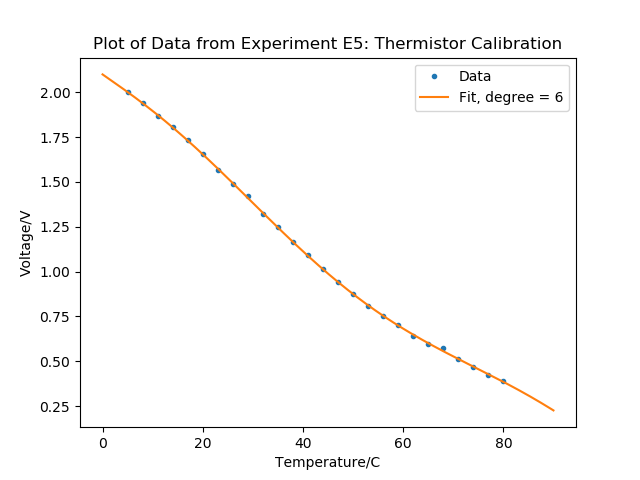

In [19]:
### STUDENT GENERATED CELL ###

degree = 6 #The degree I think is best
p2, cov2 = np.polyfit(temp,voltage,degree, cov=True) 
line2 = np.poly1d(p2)

x_values2 = np.linspace(0,90,10000) #array of x values
y_values2 = line2(x_values2) #corresponging y values


#plot:
plt.figure()
plt.plot(temp, voltage, '.', label="Data")
plt.plot(x_values2,y_values2, label="Fit, degree = 6")
plt.title("Plot of Data from Experiment E5: Thermistor Calibration")
plt.xlabel("Temperature/C")
plt.ylabel("Voltage/V")
plt.legend()
plt.show()

## Fitting the residuals to a Gaussian
#### For 2021, this section will be zero-weighted in the assessment, but if you do have time to do this you will still get feedback on it!

It would be interesting to have a closer look at the residuals. In theory, they should follow a Gaussian (normal) distribution. Do they?

<div class="alert alert-success">
<b> For 2021, this section will be zero-weighted in the assessment, but if you do have time to do this you will still get feedback on it!</b>
    
Fit the residuals to a Gaussian using scipy.stats (following the same process as we did in session 2, you can use your session 2 code as a starting point if you want), and plot them as a histogram together with the fitted Gaussian.
<br><br>
Do you think that these residuals match the expected distribution?
What relation do you notice between the standard deviation of the residuals and the experimental error on the voltage reading estimated by the student who did this experiment? Explain in a text cell.</div>

In [16]:
### STUDENT GENERATED CELL ###



### What's coming next

In this session we've seen how to fit data in a general case when we don't already know from a theoretical model what function we want to fit to. In the next session, we'll be looking at how to to use Python fit a line when we know what function we want to fit the data to.